In [1]:
import os
import wandb
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import MultilabelAccuracy

In [2]:
# Question 1: load data
data_folder = "d:/Chris/CISC881/A4/assignment4_data"
desi_rbl_data = np.load(os.path.join(data_folder, "2017 09 29 DESI 08 RBL R.npz"))
desi_rml_data = np.load(os.path.join(data_folder, "2017 10 03 DESI 04 RML L.npz"))
desi_ra_data = np.load(os.path.join(data_folder, "2017 10 05 DESI 02 RA R.npz"))

desi_rbl_image = desi_rbl_data["peaks"]
desi_rml_image = desi_rml_data["peaks"]
desi_ra_image = desi_ra_data["peaks"]

desi_rbl_x, desi_rbl_y = desi_rbl_data["dim_x"], desi_rbl_data["dim_y"]
desi_rml_x, desi_rml_y = desi_rml_data["dim_x"], desi_rml_data["dim_y"]
desi_ra_x, desi_ra_y = desi_ra_data["dim_x"], desi_ra_data["dim_y"]

In [3]:
def tic_normalization(desi_image):
    tic = np.sum(desi_image, axis=-1, keepdims=True)
    normalized_image = desi_image / tic
    return normalized_image

In [4]:
# Question 2: TIC normalization
normalized_rbl_image = tic_normalization(desi_rbl_image)
normalized_rml_image = tic_normalization(desi_rml_image)
normalized_ra_image = tic_normalization(desi_ra_image)

In [5]:
def apply_pca(desi_image):
    pca = PCA(n_components=3)
    transformed_image = pca.fit_transform(desi_image)
    return transformed_image

In [6]:
# Question 3: visualize data
# PCA to reduce dimensions to (N_allpixels, 3)
rbl_pca = apply_pca(normalized_rbl_image)
rml_pca = apply_pca(normalized_rml_image)
ra_pca = apply_pca(normalized_ra_image)

In [7]:
# Reshape to RGB (dim_x, dim_y, 3)
rbl_spatial = rbl_pca.reshape((desi_rbl_y, desi_rbl_x, -1))
rml_spatial = rml_pca.reshape((desi_rml_y, desi_rml_x, -1))
ra_spatial = ra_pca.reshape((desi_ra_y, desi_ra_x, -1))

In [8]:
def scale_image_by_channel(desi_image):
    data_min = np.min(desi_image, axis=(0, 1), keepdims=True)
    data_max = np.max(desi_image, axis=(0, 1), keepdims=True)
    scaled_image = (desi_image - data_min) / (data_max - data_min)
    return scaled_image

In [9]:
# Scale each channel to [0,1]
rbl_spatial = scale_image_by_channel(rbl_spatial)
rml_spatial = scale_image_by_channel(rml_spatial)
ra_spatial = scale_image_by_channel(ra_spatial)

In [10]:
# Save images
# plt.imsave(os.path.join(data_folder, "rbl_spatial.jpeg"), rbl_spatial)
# plt.imsave(os.path.join(data_folder, "rml_spatial.jpeg"), rml_spatial)
# plt.imsave(os.path.join(data_folder, "ra_spatial.jpeg"), ra_spatial)

In [11]:
# Question 6: dataset generation
# Load roi images
rbl_roi = sitk.ReadImage(os.path.join(data_folder, "rbl_roi.nrrd"))
rml_roi = sitk.ReadImage(os.path.join(data_folder, "rml_roi.nrrd"))
ra_roi = sitk.ReadImage(os.path.join(data_folder, "ra_roi.nrrd"))
rbl_roi_arr = sitk.GetArrayFromImage(rbl_roi)[0]  # take first channel because mask is 2D
rml_roi_arr = sitk.GetArrayFromImage(rml_roi)[0]
ra_roi_arr = sitk.GetArrayFromImage(ra_roi)[0]

In [12]:
def get_class_pixel_coordinates(roi_image, label):
    i, j = np.where(roi_image == label)
    return list(zip(i, j))  # convert list of x and y coordinates to list of (x, y) tuples

In [13]:
# Get pixels from DESI image for each class in ROI (1 = cancer, 2 = normal, 3 = background)
rbl_cancer_pixels = get_class_pixel_coordinates(rbl_roi_arr, 1)
rbl_normal_pixels = get_class_pixel_coordinates(rbl_roi_arr, 2)
rbl_background_pixels = get_class_pixel_coordinates(rbl_roi_arr, 3)

rml_cancer_pixels = get_class_pixel_coordinates(rml_roi_arr, 1)
rml_normal_pixels = get_class_pixel_coordinates(rml_roi_arr, 2)
rml_background_pixels = get_class_pixel_coordinates(rml_roi_arr, 3)

ra_cancer_pixels = get_class_pixel_coordinates(ra_roi_arr, 1)
ra_normal_pixels = get_class_pixel_coordinates(ra_roi_arr, 2)
ra_background_pixels = get_class_pixel_coordinates(ra_roi_arr, 3)

In [14]:
def get_class_spectra_and_labels(desi_image, desi_x, desi_y, pixel_coordinates, label):
    # First reshape image to (dimy, dimx, -1)
    desi_image_reshaped = desi_image.reshape((desi_y, desi_x, -1))

    # Get spectra and labels for each pixel
    spectra = []
    labels = []
    for i, j in pixel_coordinates:
        spectra.append(desi_image_reshaped[i, j, :])
        labels.append(label)

    return spectra, labels

In [15]:
# Generate spectrum and label datasets
cancer_label = np.array([0, 0, 1])
normal_label = np.array([0, 1, 0])
background_label = np.array([1, 0, 0])

# Training
rbl_cancer_spectra, rbl_cancer_labels = get_class_spectra_and_labels(normalized_rbl_image, desi_rbl_x, desi_rbl_y, rbl_cancer_pixels, cancer_label)
rbl_normal_spectra, rbl_normal_labels = get_class_spectra_and_labels(normalized_rbl_image, desi_rbl_x, desi_rbl_y, rbl_normal_pixels, normal_label)
rbl_background_spectra, rbl_background_labels = get_class_spectra_and_labels(normalized_rbl_image, desi_rbl_x, desi_rbl_y, rbl_background_pixels, background_label)

# Validation
rml_cancer_spectra, rml_cancer_labels = get_class_spectra_and_labels(normalized_rml_image, desi_rml_x, desi_rml_y, rml_cancer_pixels, cancer_label)
rml_normal_spectra, rml_normal_labels = get_class_spectra_and_labels(normalized_rml_image, desi_rml_x, desi_rml_y, rml_normal_pixels, normal_label)
rml_background_spectra, rml_background_labels = get_class_spectra_and_labels(normalized_rml_image, desi_rml_x, desi_rml_y, rml_background_pixels, background_label)

# Test
ra_cancer_spectra, ra_cancer_labels = get_class_spectra_and_labels(normalized_ra_image, desi_ra_x, desi_ra_y, ra_cancer_pixels, cancer_label)
ra_normal_spectra, ra_normal_labels = get_class_spectra_and_labels(normalized_ra_image, desi_ra_x, desi_ra_y, ra_normal_pixels, normal_label)
ra_background_spectra, ra_background_labels = get_class_spectra_and_labels(normalized_ra_image, desi_ra_x, desi_ra_y, ra_background_pixels, background_label)

X_train = np.array(rbl_cancer_spectra + rbl_normal_spectra + rbl_background_spectra)
X_val = np.array(rml_cancer_spectra + rml_normal_spectra + rml_background_spectra)
X_test = np.array(ra_cancer_spectra + ra_normal_spectra + ra_background_spectra)

y_train = np.array(rbl_cancer_labels + rbl_normal_labels + rbl_background_labels)
y_val = np.array(rml_cancer_labels + rml_normal_labels + rml_background_labels)
y_test = np.array(ra_cancer_labels + ra_normal_labels + ra_background_labels)

In [16]:
# Generate PyTorch datasets and dataloaders
X_train_tensor = torch.Tensor(X_train)
X_val_tensor = torch.Tensor(X_val)
X_test_tensor = torch.Tensor(X_test)

y_train_tensor = torch.Tensor(y_train)
y_val_tensor = torch.Tensor(y_val)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset)

In [17]:
# Generate a CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 32, 3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, 3)

        self.fc1 = nn.Linear(64 * 199, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


In [18]:
# Training settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().cuda()
metric = MultilabelAccuracy(num_labels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Log experiments
experiment = wandb.init(
    project="cisc881-desi-classification",
    config={"epochs": 25, "batch_size": 1, "learning_rate": 0.001}
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chriscyyeung. Use `wandb login --relogin` to force relogin


In [20]:
# Training loop
for epoch in range(25):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    best_val_loss = np.inf
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += metric(outputs, labels)

    # Validation step
    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_running_acc = 0.0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_running_acc += metric(outputs, labels)

    if val_running_loss < best_val_loss:
        best_val_loss = val_running_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved model")
    
    experiment.log({
        "epoch": epoch,
        "train_loss": running_loss / len(train_dataloader),
        "val_loss": val_running_loss / len(val_dataloader),
        "train_acc": running_acc / len(train_dataloader),
        "val_acc": val_running_acc / len(val_dataloader)
    })

    print(f"Epoch {epoch + 1} - Training loss: {running_loss / len(train_dataloader)} "
                            f"- Validation loss: {val_running_loss / len(val_dataloader)} "
                            f"- Training accuracy: {running_acc / len(train_dataloader)} "
                            f"- Validation accuracy: {val_running_acc / len(val_dataloader)}")

Saved model
Epoch 1 - Training loss: 0.991659420613872 - Validation loss: 0.8204411875967886 - Training accuracy: 0.7061752676963806 - Validation accuracy: 0.8206698894500732
Saved model
Epoch 2 - Training loss: 0.9897703404057622 - Validation loss: 0.8204398669448554 - Training accuracy: 0.7079163789749146 - Validation accuracy: 0.8206698894500732
Saved model
Epoch 3 - Training loss: 0.9895773186934294 - Validation loss: 0.8204398669448554 - Training accuracy: 0.707916259765625 - Validation accuracy: 0.8206698894500732
Saved model
Epoch 4 - Training loss: 0.9895773186934294 - Validation loss: 0.8204398669448554 - Training accuracy: 0.7079166173934937 - Validation accuracy: 0.8206698894500732
Saved model
Epoch 5 - Training loss: 0.9895773186934294 - Validation loss: 0.8204398669448554 - Training accuracy: 0.7079165577888489 - Validation accuracy: 0.8206698894500732
Saved model
Epoch 6 - Training loss: 0.9895773186934294 - Validation loss: 0.8204398669448554 - Training accuracy: 0.70791

In [24]:
# Question 8: prospective deployment
# Load model
best_model = CNN()
best_model.load_state_dict(torch.load("best_model.pt"))
best_model.to(device)
best_model.eval()

prediction = np.zeros((desi_ra_y, desi_ra_x, 3))
ra_image_2d = np.reshape(normalized_ra_image, (desi_ra_y, desi_ra_x, -1))
# Make prediction on each pixel
for y in range(desi_ra_y):
    for x in range(desi_ra_x):
        spectrum = ra_image_2d[y, x, :]
        spectrum_tensor = torch.Tensor(spectrum)
        spectrum_tensor = spectrum_tensor.unsqueeze(0)
        spectrum_tensor = spectrum_tensor.unsqueeze(1)
        spectrum_tensor = spectrum_tensor.to(device)
        output = model(spectrum_tensor).cpu().detach().numpy()[0]
        prediction[y, x] = np.argmax(output)

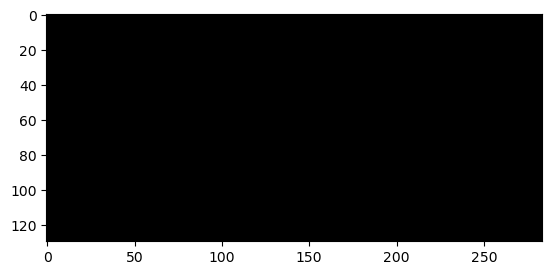

In [27]:
# Plot image
plt.imshow(prediction)
plt.show()